# Simple Variational Quantum Eigensolver
In this example, we are showing the application of TeD-Q module as a variational eigensolver. The Hamiltonian and the state vector is convert to the circuit and the energy of the state can be calculated. The result is fed into the built-in gradient descent optimizer to find the minimal energy.


## Initialization

In [1]:
import tedq as qai

# Related package
import torch
import numpy as np
import matplotlib.pyplot as plt

# Global variable
n_qubits = 4

## Hamiltonian
$H=3Z+2X+I$

In [2]:
"""
Creates a*I + b*Z + c*X + d*Y pauli sum 
that will be our Hamiltonian operator.

"""
weight = torch.tensor([1., 3., 2., 0.])

### Compute exact solution of ground state energy

#### Need to install qiskit and qiskit-aqua

In [3]:
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.algorithms import NumPyEigensolver

def hamiltonian_operator(a, b, c, d):
    """
    Creates a*I + b*Z + c*X + d*Y pauli sum 
    that will be our Hamiltonian operator.
    
    """
    pauli_dict = {
        'paulis': [{"coeff": {"imag": 0.0, "real": a}, "label": "I"},
                   {"coeff": {"imag": 0.0, "real": b}, "label": "Z"},
                   {"coeff": {"imag": 0.0, "real": c}, "label": "X"},
                   {"coeff": {"imag": 0.0, "real": d}, "label": "Y"}
                   ]
    }
    return WeightedPauliOperator.from_dict(pauli_dict)
H = hamiltonian_operator(weight[0], weight[1], weight[2], weight[3])
exact_result = NumPyEigensolver(H).run()
reference_energy = min(np.real(exact_result.eigenvalues))
print('The exact ground state energy is: {}'.format(reference_energy))

The exact ground state energy is: -2.6055512754639896


## Circuit Definition

#### Eigenvalue of hamiltonian 

E = $\langle \psi |H|\psi\rangle = 3\langle\psi | Z|\psi\rangle+\langle\psi | X|\psi\rangle+\langle\psi | I|\psi\rangle $

#### Ansatz wavefunction

$|\psi\rangle = R_y (\theta) |0\rangle = c_z^1|0\rangle+c_z^2|1\rangle = c_y^1|+i\rangle+c_y^2|-i\rangle = c_x^1|+\rangle+c_x^2|-\rangle$

In [4]:
def ansatz(theta):
    for j in range(n_qubits):
        qai.RY(theta[j], qubits=[j])

In [5]:
def circuitDef(theta):
    ansatz(theta)
    
    qai.Hadamard(qubits=[2])
    qai.S(qubits=[3])
    qai.Hadamard(qubits=[3])
    
    qai.measurement.expval(qai.I(qubits=[0]))
    qai.measurement.expval(qai.PauliZ(qubits=[1]))
    qai.measurement.expval(qai.PauliZ(qubits=[2]))
    qai.measurement.expval(qai.PauliZ(qubits=[3]))

In [6]:
circuit = qai.Circuit(circuitDef, n_qubits, torch.zeros(n_qubits))
compiledCircuit = circuit.compilecircuit('pytorch')

log10(flops) of this quantum circuit:   2.5263392773899733


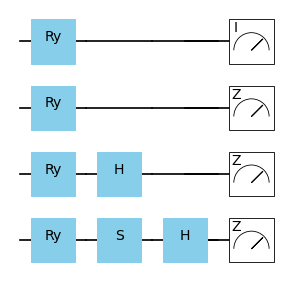

In [7]:
drawer = qai.matplotlib_drawer(circuit, figsize=(5,5), scale=1.4)
drawer.draw_circuit()

## Optimization

### Define cost function


In [8]:
def cost(*params):
    x = params[0]
    exp_val = compiledCircuit(x*torch.ones([n_qubits], requires_grad=True))
    return torch.dot(weight,exp_val)

### Define optimizer

In [9]:
Optimizer = qai.GradientDescentOptimizer(cost, [0], 0.1, interface="pytorch")

In [10]:
init_value = torch.tensor(0.3, requires_grad=True)

### Optimization

In [11]:
new_params = (init_value)

opt_t_list = np.array([])
opt_c_list = np.array([])

opt_t_list = np.append(opt_t_list, new_params.item())
opt_c_list = np.append(opt_c_list, cost(new_params).item())
for i in range(100):
    new_params = Optimizer.step(new_params)[0]
    if (i + 1) % 5 == 0:
        opt_t_list = np.append(opt_t_list, new_params.item())
        opt_c_list = np.append(opt_c_list, cost(new_params).item())
    if (i + 1) % 20 == 0:
        
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(new_params)))
        print("Parameters after step {:5d}: {}".format(i + 1, new_params))
computed_energy = cost((new_params))

Cost after step    20: -2.6055133
Parameters after step    20: -2.549006223678589
Cost after step    40: -2.6055512
Parameters after step    40: -2.553589344024658
Cost after step    60: -2.6055508
Parameters after step    60: -2.5535898208618164
Cost after step    80: -2.6055508
Parameters after step    80: -2.5535898208618164
Cost after step   100: -2.6055508
Parameters after step   100: -2.5535898208618164


### Plot

In [12]:
t_list = np.linspace(0, 2*np.pi, 101)
c_list = np.array([])
for t in t_list:
    c_list = np.append(c_list, cost(t).item())

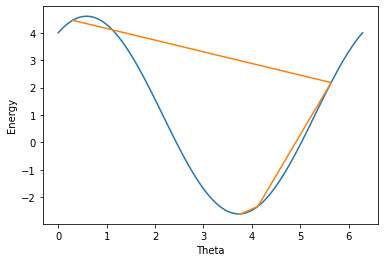

In [13]:
plt.plot(t_list, c_list)
plt.plot((opt_t_list)%(2*np.pi), opt_c_list)
plt.xlabel('Theta')
plt.ylabel('Energy')
plt.show()

## Result

In [14]:
print('The exact ground state energy is: \t{: .7f}'.format(reference_energy))
print('The computed ground state energy is: \t{: .7f}'.format(computed_energy))
print('Error is {: .5f}%'.format((computed_energy-reference_energy)/computed_energy*100))

The exact ground state energy is: 	-2.6055513
The computed ground state energy is: 	-2.6055508
Error is -0.00002%
